In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import neuralnet as nn

sns.set_palette('husl')

In [2]:
sdss_data = pd.read_csv('Skyserver_objects_ds_12.csv')

In [3]:
sdss_data.tail()

,class,run,camcol,rerun,field,objid,u,g,r,i,z,ra,dec,specobjid,plate,mjd,fiberid,redshift
20353,GALAXY,752,6,301,92,1237648705639416184,26.04972,22.39536,20.38941,19.35793,18.84246,157.326047,0.873352,4314677505052831744,3832,55289,833,0.539871
20354,STAR,1241,2,301,150,1237650803734741295,21.49449,20.40386,20.21281,20.21889,20.46793,160.902724,-2.918764,4245784034879926272,3771,55544,56,0.000869
20355,GALAXY,1458,5,301,464,1237651737373836023,24.77447,22.93241,21.49690,20.12395,19.64682,194.303287,3.195364,5355920795099656192,4757,55653,54,0.656553
20356,QSO,756,4,301,344,1237648721762058462,21.22846,20.45185,20.54100,20.54968,20.19005,167.398976,0.323752,4320297938364067840,3837,55572,800,2.323997
20357,GALAXY,1402,2,301,82,1237651495220020104,23.66409,24.11156,21.64051,20.58134,19.80171,118.754578,43.367616,7178798384345182208,6376,56269,220,0.660069


#### Featuresreset_index

In [4]:
sdss_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20358 entries, 0 to 20357
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   class      20358 non-null  object 
 1   run        20358 non-null  int64  
 2   camcol     20358 non-null  int64  
 3   rerun      20358 non-null  int64  
 4   field      20358 non-null  int64  
 5   objid      20358 non-null  int64  
 6   u          20358 non-null  float64
 7   g          20358 non-null  float64
 8   r          20358 non-null  float64
 9   i          20358 non-null  float64
 10  z          20358 non-null  float64
 11  ra         20358 non-null  float64
 12  dec        20358 non-null  float64
 13  specobjid  20358 non-null  int64  
 14  plate      20358 non-null  int64  
 15  mjd        20358 non-null  int64  
 16  fiberid    20358 non-null  int64  
 17  redshift   20358 non-null  float64
dtypes: float64(8), int64(9), object(1)
memory usage: 2.8+ MB


Details about more important features.
+ ra, dec — right ascension and declination respectively
+ u, g, r, i, z — filter bands (a.k.a. photometric system or astronomical magnitudes)
+ run, rerun, camcol, field — descriptors of fields (i.e. 2048 x 1489 pixels) within image
+ redshift — increase in wavelength due to motion of astronomical object
+ plate — plate number
+ mjd — modified Julian date of observation
+ fiberid — optic fiber ID
+ class - category of an object, that will be our dependent variable

In [5]:
grouped_desc = sdss_data.groupby(['class']).describe()

In [6]:
sdss_data.nunique().to_frame().T

,class,run,camcol,rerun,field,objid,u,g,r,i,z,ra,dec,specobjid,plate,mjd,fiberid,redshift
0,3,31,6,1,682,18099,17818,17642,17580,17664,17684,18099,18099,20358,432,304,1000,20277


#### Univariate analysis

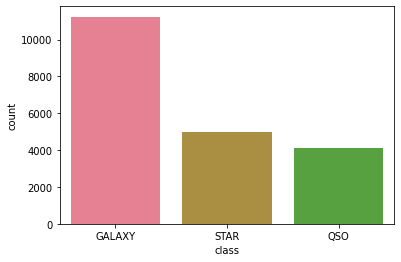

In [7]:
# counts of observations in each categorical bin
ax = sns.countplot(x='class', data=sdss_data)

In [8]:
occurances = sdss_data['class'].value_counts().to_frame().rename(
    index=str, columns={'class': 'Occurances'})
occurances

,Occurances
GALAXY,11243
STAR,4992
QSO,4123


More than half of observations are galaxies.

In [9]:
sdss_data.run.unique()

array([ 752, 1462, 1907, 1402, 1350, 1331,  756, 1895, 1345, 1458, 1904,
       1140, 1412, 1239, 1231, 1473, 1045, 2074, 1404, 1241, 1729,  109,
         94, 1302,  308, 1478, 1477,  745, 1329, 1119,  259])

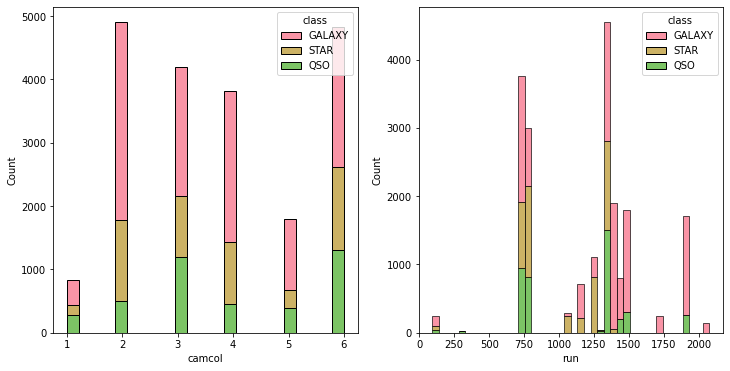

In [10]:
xs = ['camcol', 'run']
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

for i in range(len(xs)):
    axes[i] = sns.histplot(sdss_data, x=xs[i], hue='class',
                           multiple='stack', ax=axes[i])

,redshift
class,
GALAXY,0.503228
QSO,2.110945
STAR,0.000170


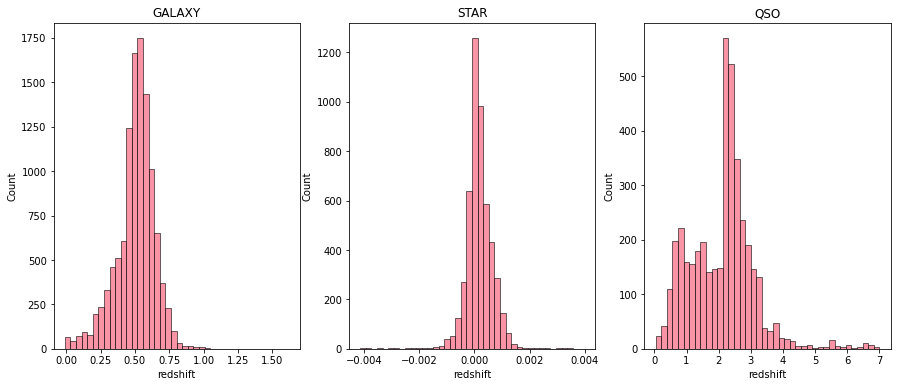

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

for i in range(len(occurances)):
    ax = sns.histplot(sdss_data[sdss_data['class'] ==
                                occurances.index[i]].redshift, bins=40, ax=axes[i])
    ax.set_title(occurances.index[i])

# mean of redshift for every class
sdss_data.groupby(by='class')['redshift'].mean().to_frame()

As it seems there are significant differences amongst classification classes, especially QSO (quasars) stands out.
+ **GALAXY** distribution of redshift values seems to be shifted to the right. Most samples lie around 0.055
+ **STAR** redshift histogram is centered around 0, and most of the observations lie between -0.002 and 0.002

##### Dec
Let's visualize dec feature as violin plots.

<AxesSubplot:xlabel='dec', ylabel='class'>

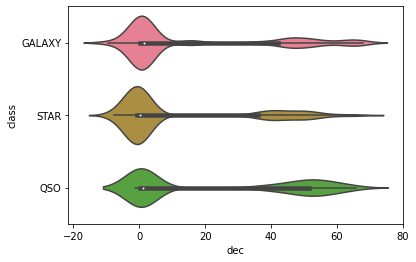

In [12]:
sns.violinplot(y=sdss_data['class'], x=sdss_data['dec'])

Most of data points of each class lie around 0 and between 40 - 70, because violinplots are the widest there.

<AxesSubplot:xlabel='class', ylabel='mjd'>

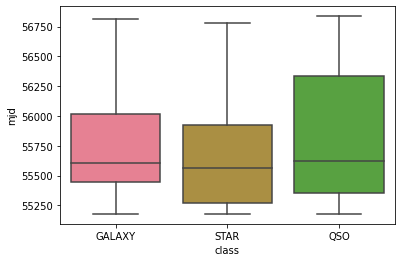

In [13]:
sns.boxplot(x='class', y='mjd', data=sdss_data)

##### Multivariative analysis

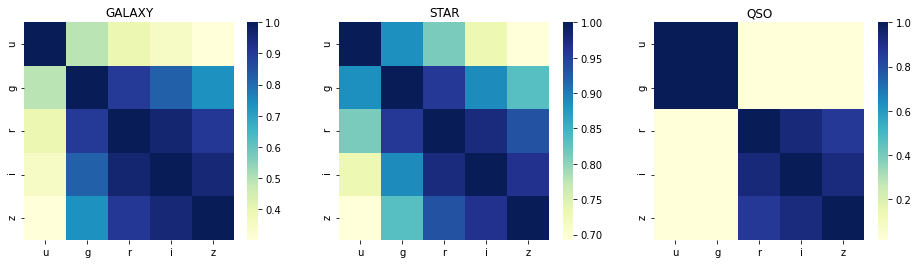

In [14]:
# names of filter bands columns
filter_bands = ['u', 'g', 'r', 'i', 'z']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
cmap = "YlGnBu"

# plotting
for i in range(len(occurances)):
    corr = sdss_data[sdss_data['class'] ==
                     occurances.index[i]][filter_bands].corr()
    ax = sns.heatmap(corr, cmap=cmap, ax=axes[i])
    ax.set_title(occurances.index[i])

At the beggining it is worth pointing out that correlation maps look very similar for Galaxies and Stars. Hence, we can assume that different bands behave similarily for those classes.
The correlation matrices above show that some of the features are strongly correlated. I assume it is not something odd, because if there is an object captured by one of the bands, the other should capture something aswell.

Dimensionality reduction will probably increase accuracy of a classifier.

In [15]:
sdss_data
sdss_data[filter_bands].corr()

,u,g,r,i,z
u,1.000000,0.999852,0.015067,0.006615,0.004668
g,0.999852,1.000000,0.017415,0.010200,0.008256
r,0.015067,0.017415,1.000000,0.921864,0.846915
i,0.006615,0.010200,0.921864,1.000000,0.958625
z,0.004668,0.008256,0.846915,0.958625,1.000000


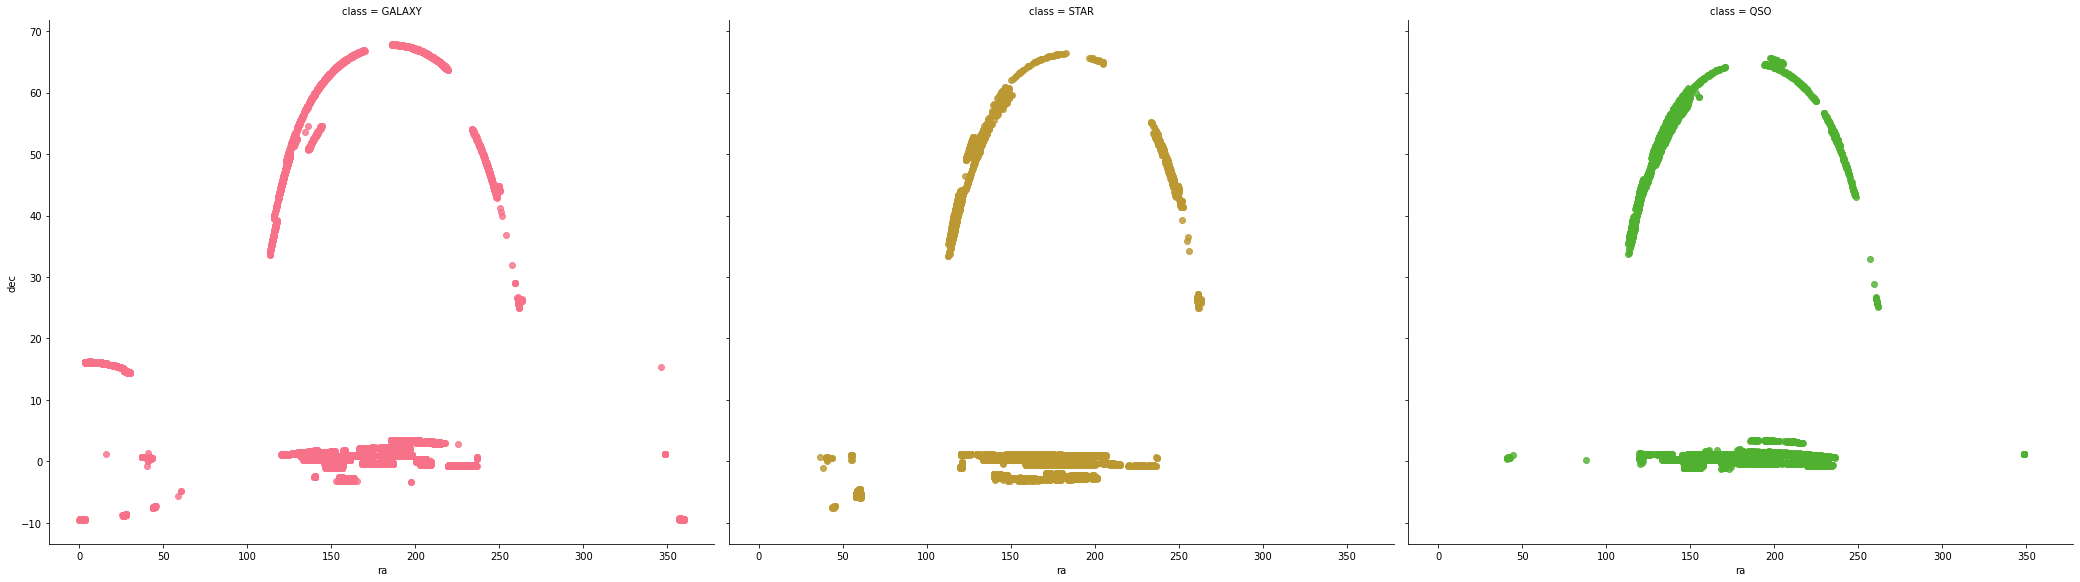

In [16]:
sns.lmplot(x='ra', y='dec', data=sdss_data, col='class',
           aspect=1.2, height=8, hue='class', fit_reg=False)

Here are plotted **dec** against **ra** values for each class object.
Amongst categories of objects most of the groups of data points seem to be similar. There are some clusters that belong to only one class. 

,plate,mjd
plate,1.000000,0.939648
mjd,0.939648,1.000000


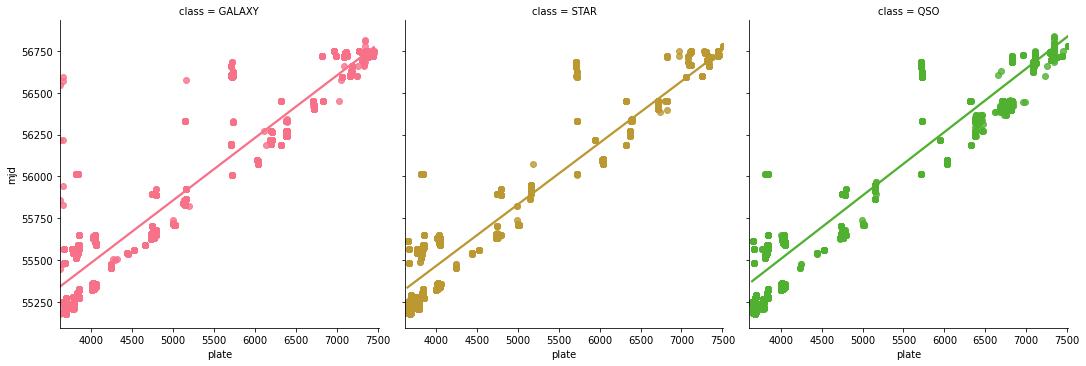

In [17]:
sns.lmplot(x='plate', y='mjd', data=sdss_data, col='class', hue='class')
sdss_data[['plate', 'mjd']].corr()

'**mijd**' and '**plate**' seem to be lineary coorelated, thus plate column will be removed.

#### Feature engineering

'**rerun**' column has only 1 value even though the provided data set has around 20000 records. Therefore it can be dropped, since it won't affect classification.
'**objid**' and '**specobjid**' are ids for accessing the rows in the original database.

Hence, they might be removed from data set, because they won't be related to the outcome of prediction.
Summarizing, these variables won't affect predictions of model, thus they can be removed.

More features to remove: **camcol**, **field**, **fiberid**, **run**, **plate**

In [18]:
sdss_data.groupby('class').mean()

,run,camcol,rerun,field,objid,u,g,r,i,z,ra,dec,specobjid,plate,mjd,fiberid,redshift
class,,,,,,,,,,,,,,,,,
GALAXY,1296.045451,3.650627,301.0,240.773726,1.237651e+18,23.829993,21.906185,20.295857,19.382390,18.949002,159.208621,15.638214,5.299049e+18,4706.373388,55747.852086,523.408521,0.503228
QSO,1117.642008,3.993451,301.0,289.390735,1.237650e+18,19.717012,18.616896,20.721379,20.551191,20.324398,168.267999,22.607516,5.440519e+18,4832.024497,55821.520737,520.322338,2.110945
STAR,1018.062500,3.778646,301.0,232.585136,1.237650e+18,21.938177,20.432247,19.942759,19.693122,19.539174,158.363837,11.580710,5.158543e+18,4581.587941,55678.469551,487.106170,0.000170


In [19]:
# removing redundant columns
# most of them refers to some kind of an id

cols_to_drop = ['objid', 'specobjid', 'camcol',
                'rerun', 'field', 'plate', 'fiberid', 'run']
sdss_data.drop(columns=cols_to_drop, inplace=True)

# Reducing dimensionality using PCA

In [20]:
# Standarization
filter_bands = ['u', 'g', 'r', 'i', 'z']

filters = sdss_data.loc[:, filter_bands].values
standarized_filters = StandardScaler().fit_transform(filters)

In [21]:
# principal component analysis
pca_u_g = PCA(n_components=1)
pca_r_i_z = PCA(n_components=2)
sdss_pca_u_g = pd.DataFrame(pca_u_g.fit_transform(standarized_filters[:, :2]), columns=['PCA_u_g_0'])
sdss_pca_r_i_z = pd.DataFrame(pca_r_i_z.fit_transform(standarized_filters[:, 2:]), columns=['PCA_r_i_z_0', 'PCA_r_i_z_1'])

# remove old column and add 
sdss_after_pca = pd.concat((sdss_data, sdss_pca_r_i_z, sdss_pca_u_g), axis=1)
sdss_after_pca.drop(filter_bands, axis=1, inplace=True)

In [22]:
sdss_after_pca.head()

,class,ra,dec,mjd,redshift,PCA_r_i_z_0,PCA_r_i_z_1,PCA_u_g_0
0,GALAXY,181.970925,-0.367202,55321,0.422777,2.449977,-0.048229,-0.003714
1,GALAXY,189.215634,2.197783,55649,0.668512,0.879094,-0.343067,-0.020300
2,GALAXY,136.355371,1.462998,55532,0.612269,0.975897,-0.352402,-0.026624
3,GALAXY,120.314530,45.027188,56245,0.653417,-1.202186,-0.812387,-0.058416
4,GALAXY,137.933601,58.909497,56605,0.516920,0.243226,-0.310078,-0.045466


# Splitting data

In [23]:
X = sdss_after_pca.drop('class', axis=1)
y = pd.get_dummies(sdss_after_pca['class'])

In [24]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=.8, random_state=77)

# Standarization
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=77)

# Classification

In [26]:
network = nn.NeuralNetwork(nn.tanh)

network.add(nn.Dense(7, 14))
network.add(nn.Dense(14, 10))
network.add(nn.Dense(10, 5))
network.add(nn.Dense(5, 3))

In [27]:
network.train(X_train, y_train, X_val, y_val, 300,
              learning_rate=.1, w=.9, fi1=.3, fi2=.7, particles_in_swarm=50, verbose=False)

Generation 1/300	best cost = 0.52226	train acc=>0.549	val acc=>0.552
Generation 75/300	best cost = 0.23185	train acc=>0.761	val acc=>0.761
Generation 150/300	best cost = 0.05960	train acc=>0.940	val acc=>0.940
Generation 225/300	best cost = 0.03360	train acc=>0.967	val acc=>0.967
Generation 300/300	best cost = 0.02587	train acc=>0.976	val acc=>0.975

Training time: 3270.93s


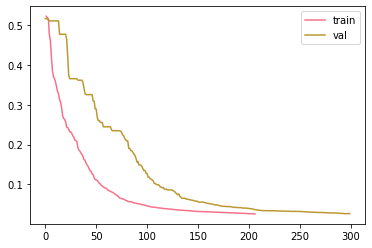

In [28]:
fig, ax = plt.subplots()

ax.plot(network.history_train, label='train')
ax.plot(network.history_val, label='val')
ax.legend()

# fig.show()

# Results

### Predict test

In [29]:
y_test.reset_index(inplace=True, drop=True)

In [30]:
y_pred = network.predict(X_test)

### Classification report

In [31]:
print(classification_report(y_test, y_pred))

acc = np.sum((y_test == y_pred).all(axis=1)) / len(y_test)
print(f'\nAccuracy = {acc:.3f}')

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2281
           1       0.99      0.92      0.95       814
           2       0.97      0.99      0.98       977

   micro avg       0.97      0.97      0.97      4072
   macro avg       0.97      0.96      0.97      4072
weighted avg       0.97      0.97      0.97      4072
 samples avg       0.97      0.97      0.97      4072


Accuracy = 0.972


Text(0.5, 1.0, 'Confusion matrix')

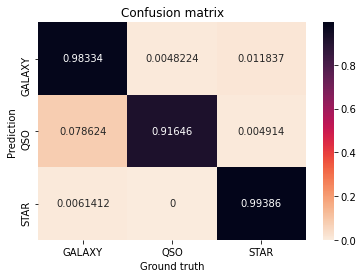

In [32]:
conf_matrix = confusion_matrix(y_test.idxmax(axis=1), y_pred.idxmax(axis=1), labels=y_test.columns.to_list())
conf_matrix_norm = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)

ax = sns.heatmap(pd.DataFrame(conf_matrix_norm), cmap=sns.cm.rocket_r, annot=True, fmt='.5g', xticklabels=y_test.columns.to_list(), yticklabels=y_test.columns.to_list())
ax.set(xlabel='Ground truth', ylabel='Prediction')
ax.set_title('Confusion matrix')